# Introduction to Inverse Problems

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2017  
> Email: [samuel.farrens@gmail.com](mailto:samuel.farrens@gmail.com)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Linear Regression](#Linear-Regression)
 * [Mathematical Representation 1](#Mathematical-Representation-1)
 * [Straight Line Example](#Straight-Line-Example)
 * [Exercise 1](#Exercise-1)
1. [Deconvolution](#Deconvolution)
 * [Mathematical Representation 2](#Mathematical-Representation-2)
 * [Ideal PSF Example](#Ideal-PSF-Example)
 * [Exercise 2](#Exercise-2)
 * [Gradient Descent](#Gradient-Descent)
1. [Hints](#Hints)
1. [Exercise Solutions](#Exercise-Solutions)
 * [Exercise 1 Solution](#Exercise-1-Solution)
 * [Exercise 2 Solution](#Exercise-2-Solution)

---

## Set-Up

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy.ndimage import gaussian_filter
from scipy.misc import ascent

# Import interaction module
from ipywidgets.widgets import *

---

## Introduction

A standard "forward" problem is one in which data is obtained from model parameters, *i.e.*

$$\text{Model}\rightarrow\text{Data,}$$

while inverse problem is one in which the model parameters are determined from the data, *i.e.*

$$\text{Data}\rightarrow\text{Model.}$$

In other words, with an inverse problem one attempts to obtain information about a physical system from observed measurements. This can be very useful as some model parameters can not be measured directly.

Inverse problems have been applied various topics such as oceanography, weather prediction, astrophysics, medical imaging and geophysics.

> See the following links for more information about inverse problems:
> * [Wikipedia](https://en.wikipedia.org/wiki/Inverse_problem)
> * [Scatting Ideas](https://cmontalto.wordpress.com/2013/03/08/what-are-inverse-problems/)


---

## Linear Regression

### <font color='blue'>Mathematical Representation 1</font>

We will start by defining some variables. We will use $Y \in \mathbb{R}^{m}$ to represent data measurements/observations, $A \in \mathbb{R}^{n}$ to represent a given model and $X \in \mathbb{R}^{m \times n}$ to represent a matrix of equations that relate the model parameters to the measured data. Now, we can pose a given problem as follows:

$$Y = XA$$

When dealing with forward problems $X$ and $A$ are known and can be used to obtain $Y$. For inverse problems $X$ and $Y$ are known and can be used to obtain $A$.

### <font color='blue'>Straight Line Example</font>  

The best place to start is with something that should be intimately familiar to anyone with even the most basic background in mathematics, a straight line.


#### Equation of a Straight Line

A simple straight line can be represented with the following well known equation:

$$y = mx + b$$

where $m$ is the gradient or slope of the line and $b$ is the point where the line intercepts the $y$-axis. In Python we can implement the following function to represent this equation:

In [2]:
# Define the function y(x).
# This defines a function called y_func with input variables x, m and b, and returns the values of mx + b.
def y_func(x, m, b):
    
    return m * x + b

#### Forward Problem

A straightforward way to approach this problem is, when we have some data on the x-axis,

$$x = \begin{bmatrix} 8 & 2 & 11 & 6 & 5 & 4 & 12 & 9 & 6 & 11 \end{bmatrix}$$

and we know the slope and intercept of the line,

$$m = -1.1$$

$$b = 14.0,$$

then we simply plug this information into the equation above to get the corresponding data on the y-axis. To think of the of this in terms of a forward problem, however, we need to know that the slope and intercept correspond to our model parameters and the data on the x-axis needs to be converted into a matrix operator. So, a better way of representing our line equation would be:

$$y = a_0x^0 + a_1x^1$$

Then, in terms of our forward problem formulation ($Y=XA$), 

$$A = \begin{bmatrix} a_0 & a_1 \end{bmatrix}$$

and

$$X = \begin{bmatrix} 
1 & 8 \\
1 & 2 \\
1 & 11 \\
1 & 6 \\
1 & 5 \\
1 & 4 \\ 
1 & 12 \\
1 & 9 \\
1 & 6 \\
1 & 11 
\end{bmatrix}$$

We can implement this in python as follows:

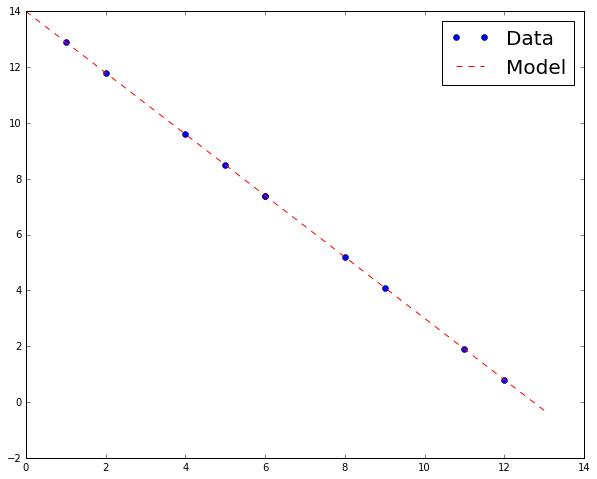

In [3]:
# Set points in x-axis.
x = np.array([8, 2, 11, 6, 5, 4, 12, 9, 6, 1])

# Define the matrix operator.
X = np.array([np.ones(x.size), x]).T

# Set the model values.
A = np.array([14.0, -1.1])

# Calculate Y.
Y = np.dot(X, A)

# Plot results.
plt.plot(x, Y, 'bo', label='Data')
plt.plot(np.arange(14), y_func(np.arange(14), A[1], A[0]), 'r--', label='Model')
plt.legend(fontsize=20)
plt.show()

#### Inverse Problem

For the inverse problem we will assume we already know $Y$ and use this to work out $X$, so in other words we already have a set of data points and we want to work out the best fitting line.

$$x = \begin{bmatrix} 8 & 2 & 11 & 6 & 5 & 4 & 12 & 9 & 6 & 11 \end{bmatrix}$$

$$y = \begin{bmatrix} 3 & 10 & 3 & 6 & 8 & 12 & 1 & 4 & 9 & 14 \end{bmatrix}$$

and again

$$X = \begin{bmatrix} 
1 & 8 \\
1 & 2 \\
1 & 11 \\
1 & 6 \\
1 & 5 \\
1 & 4 \\ 
1 & 12 \\
1 & 9 \\
1 & 6 \\
1 & 11 
\end{bmatrix}$$

to solve this problem we need to invert $X$ *i.e.*

$$A = X^{-1}Y$$

however, $X$ is not a square matrix which means it cannot be inverted directly. So, first we need to multiply by $X^{T}$.

> Because $X \in \mathbb{R}^{m \times n}$ and $X^{T} \in \mathbb{R}^{n \times m}$ so $X^{T}X \in \mathbb{R}^{n \times n}$

So, the solution is

$$A = (X^TX)^{-1}X^{T}Y$$

which is often called the [Normal Equation](http://mathworld.wolfram.com/NormalEquation.html). We can implement this in python as follows:

A = [ 14.08108108  -1.10641892]


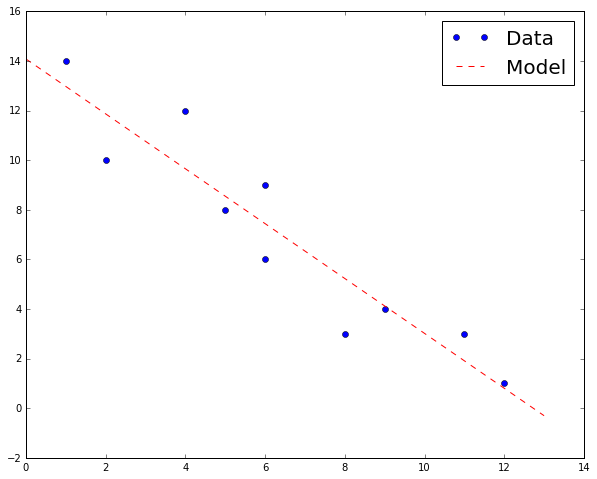

In [4]:
# This function implements the normal equation
def normal_eq(X, y):
    
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

# M is already defined in the notebook.

# Set points in y-axis.
y = np.array([3, 10, 3, 6, 8, 12, 1, 4, 9, 14])

# Find model parameters.
A = normal_eq(X, y)

print 'A =', A

# Plot results.
plt.plot(x, y, 'bo', label='Data')
plt.plot(np.arange(14), y_func(np.arange(14), A[1], A[0]), 'r--', label='Model')
plt.legend(fontsize=20)
plt.show()

### <font color='red'>Exercise 1</font>

For this exercise you should apply the techniques learned for fitting a straight line to a set of data points to a new set of data that requires a polynomial fit.

#### Equation of a Polynomial Line

The expression for a straigh line (*i.e.* $k = 1$) generalises to the following form for a $k^{\textrm{th}}$ degree polynomial:

$$y = a_0 + a_1x + a_2x^2 + ... + a_kx^k$$

where $a_i$ are the polynomial coefficients. We can represent this in Python with the following function:

In [5]:
#############################
# NO NEED TO EDIT THIS CELL #
#############################

# Define the new function y(x) for any kth degree polynomial.
# This defines a function called y_func2 with input variables x and a, and returns the values of a0 + a1x + a2x^2 + ...
def y_func2(x, a):
    
    return sum([(a_i * x ** n) for a_i, n in zip(a, range(a.size))])

The data for this exercise are the following:

| x    | y     |
|:----:|:-----:|
| 0.00 | 0.486 | 
| 0.05 | 0.866 | 
| 0.10 | 0.944 | 
| 0.15 | 1.144 | 
| 0.20 | 1.103 | 
| 0.25 | 1.202 | 
| 0.30 | 1.166 |
| 0.35 | 1.191 | 
| 0.40 | 1.124 | 
| 0.45 | 1.095 | 
| 0.50 | 1.122 |
| 0.55 | 1.102 |
| 0.60 | 1.099 |
| 0.65 | 1.017 |
| 0.70 | 1.111 |
| 0.75 | 1.117 |
| 0.80 | 1.152 |
| 0.85 | 1.265 |
| 0.90 | 1.380 |
| 0.95 | 1.575 |
| 1.00 | 1.857 |

These values have already been defined for you.

In [6]:
#############################
# NO NEED TO EDIT THIS CELL #
#############################

# The values for x and y.
x = np.linspace(0.0, 1.0, 21)
y = np.array([0.486, 0.866, 0.944, 1.144, 1.103, 1.202, 1.166, 1.191, 1.124, 1.095, 1.122, 1.102, 1.099, 1.017, 1.111, 
              1.117, 1.152, 1.265, 1.380, 1.575, 1.857])

Your job is to define the matrix operator $X$ and find the model parameters $A$ by solving the inverse problem $Y=XA$.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [7]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Define the matrix operator X here:
X = None

# Calculate the model parameters A here:
A = None

Now you can test how well your model line fits the data.

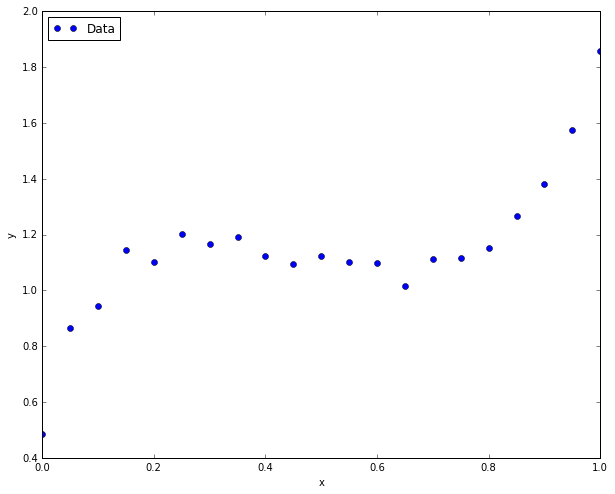

In [8]:
#############################
# NO NEED TO EDIT THIS CELL #
#############################

# Display the plot.
plt.plot(x, y, 'bo', label='Data') 
if not isinstance(A, type(None)):
    plt.plot(x, y_func2(x, A), 'g-', label='Model')
    plt.title('Best Fit Polynomial: k =' + str(len(A) - 1))
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

---

## Deconvolution

### <font color='blue'>Mathematical Representation 2</font>

We will define $Y \in \mathbb{R}^{m \times n}$ to represent an observed image, $X \in \mathbb{R}^{m \times n}$ to represent a "true" image and $M \in \mathbb{R}^{m \times m}$ to represent a distortion matrix so that we have an inverse problem of the following form:

$$Y = MX$$

In this case we wish to recover the true image, $X$, given some observed image, $Y$, and assuming that the distortion matrix, $M$, is known.

### <font color='blue'>Ideal PSF Example</font>

We will start with an example of an image convolved with a known Point Spread Function (PSF). We can generate an idealised PSF in Python as follows:

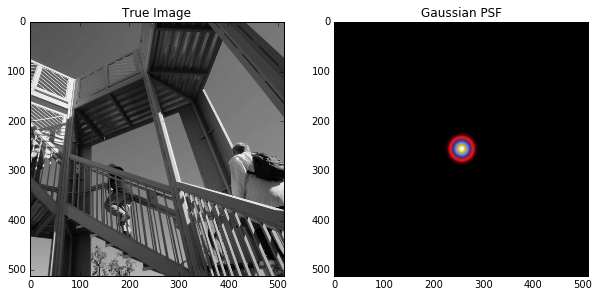

In [9]:
# Define true image.
X = ascent()

# Generate a Gaussian PSF.
M = np.zeros(X.shape)
M[zip(np.array(M.shape) / 2)] = 1
M = gaussian_filter(M, 10)

# Display.
plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('True Image')
plt.subplot(122)
plt.imshow(M, cmap='gist_stern')
plt.title('Gaussian PSF')
plt.show()

** Forward Problem **

Now we need to define our distortion matrix, which in this case will be the convolution of the PSF with the true image.

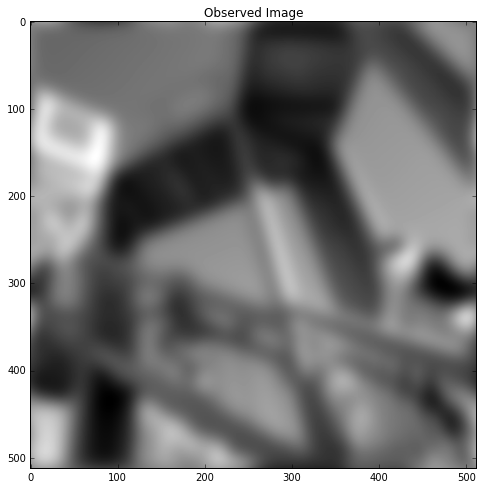

In [10]:
# This function convolves an image with a kernel using FFT.
def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

# Produce the observed image.
Y = fftconvolve(X, M)

# Display
plt.imshow(Y, cmap='gray')
plt.title('Observed Image')
plt.show()

As you can see the PSF has blurred the true image.

** Inverse Problem **

The inverse problem corresponds to deconvolving the PSF effects from the image. In an ideal scenario this is simply: 

$$X = M^{-1}Y$$

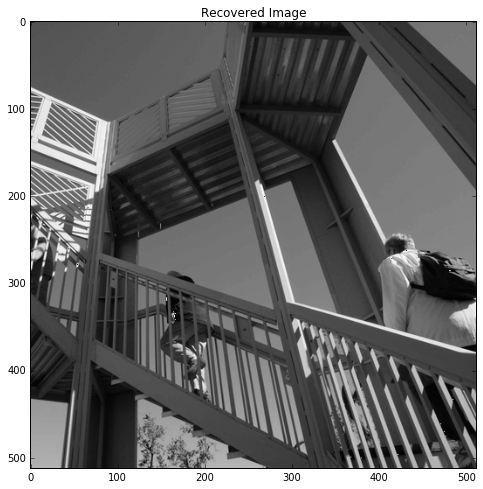

In [11]:
# This function deconvolves an image with a kernel using FFT.
def fftdeconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x / y))))

# Recover the original image.
X_rec = fftdeconvolve(Y, M)

# Display
plt.imshow(X_rec, cmap='gray')
plt.title('Recovered Image')
plt.show()

### <font color='red'>Exercise 2</font>

For this exercise you need to add noise to the observed image and attempt to recover the true image.

The new problem can be posed as follows:

$$Y = MX + N$$

where $N$ corresponds to an additive noise component. Start by adding random noise to the observed image.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [12]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Set the noise level.
sigma = None

# Define the noise.
N = None

# Add noise to the observed image.
Y_noisy = None

Now you can see what the noisy image looks like.

In [13]:
#############################
# NO NEED TO EDIT THIS CELL #
#############################

# Display
if not isinstance(Y_noisy, type(None)):
    plt.imshow(Y_noisy, cmap='gray')
    plt.title('Noisy Observed Image')
    plt.show()

Attempt to deconvolve the PSF effects from this noisy image.

<br />
<font color='red'>EDIT THE CELL BELOW</font>

In [14]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Recover the original image.
X_rec = None

Let's see what happens.

In [15]:
#############################
# NO NEED TO EDIT THIS CELL #
#############################

# Display
if not isinstance(X_rec, type(None)):
    plt.imshow(X_rec, cmap='gray')
    plt.title('Recovered Image')
    plt.show()

Did it work?

Try reducing the noise level and see what happens. Does this improve the results or not?

### <font color='blue'>Gradient Descent</font>

Since we cannot use an analytical method to solve this problem we can instead try an iterative method such as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), which searches for the local optimum of a function from a given starting position.

For this approach we want to define a convex function that measures the accuracy of a given reconstruction. One way to test the accuracy is to measure the residual, $Y-MX$, for a given estimate of $X$. With a convex function, like the l2-norm, we will be searching for the global minimum of the residual:

$$F(X) = \frac{1}{2}\|MX-Y\|_2^2$$

The corresponding gradient is:

$$\nabla F(X) = M^{T}(MX-Y)$$

**L2-Norm**

The l2 or Euclidian norm is calculated as follows:

$$\|x\|_2 = \Big(\sum_{i=1}^n|x_i|^2\Big)^{\frac{1}{2}}$$

We can show that this function is convex in Python. 

In [16]:
@interact_manual(point=(0, 99, 1))
def show_grad(point=20):
    
    x = np.linspace(-1, 1, 100)
    y1 = np.array([np.linalg.norm(xi) for xi in x])
    y2 = np.array([np.linalg.norm(xi) ** 2 for xi in x])
    dy = x[point] ** 2 + 2 * x[point] * (x - x[point])

    print 'Gradient =', 2 * x[point]

    # Display
    plt.plot(x, y1, 'b-', label='$||x||_2$')
    plt.plot(x, y2, 'g-', label='$||x||_2^2$')
    plt.plot(x[point], y2[point], 'ro')
    plt.plot(x, dy, 'r--', label='Grad $||x_i||_2^2$')
    plt.ylim(-0.1, 1.0)
    plt.title('Convex L2-Norm')
    plt.xlabel('$x$', fontsize=24)
    plt.legend(loc='upper center', fontsize=20)
    plt.show()

The plot clearly shows that both $\|x\|_2$ and $\|x\|_2^2$ have a clearly defined global minimum. The plot also displays the gradient of $\|x\|_2^2$ at the point $x_{20}$, try ajusting the position of this point and see what happens to the gradient.

Unsurprisingly, as the point apporachs the minimum the gradient tends to zero. Also, depending on which side of the minimum the point is, the gradient will be either positive or negative. Gradient descent captialises on this by iteratively updating solutions in the following way:

$$X_{n+1} = X_n - \gamma \nabla F(X)$$

where $X_n$ corresponds to the solution at given iteration. So, as the gradient approaches zero and consequenly as $X$ approaches the global minimum the solution will converge. 

Now, we can try this apporach to try to recover the original image. 

First we need to define $M^{T}$. Fortuneately this simply corresponds to rotating the PSF by $90^\circ$. So, we can define the gradient as follows:

In [17]:
# This function calculates the gradient for a given reconstruction.
def grad(image, rec, kernel):

    return fftconvolve(fftconvolve(rec, kernel) - image, np.rot90(kernel))

Let's see if it works.

1 F(X) = 4254.6977095
2 F(X) = 2509.44781206
3 F(X) = 1888.0042287
4 F(X) = 1562.87256656
5 F(X) = 1355.62136941
6 F(X) = 1208.33983811
7 F(X) = 1096.64162677
8 F(X) = 1008.22365745
9 F(X) = 936.058004321
10 F(X) = 875.771815396
11 F(X) = 824.474769385
12 F(X) = 780.169213812
13 F(X) = 741.425761247
14 F(X) = 707.192446869
15 F(X) = 676.676543133
16 F(X) = 649.268373093
17 F(X) = 624.490580178
18 F(X) = 601.96342383
19 F(X) = 581.380483619
20 F(X) = 562.49130419
21 F(X) = 545.088775517
22 F(X) = 528.99980915
23 F(X) = 514.078349792
24 F(X) = 500.200068048
25 F(X) = 487.258280868
26 F(X) = 475.160780237
27 F(X) = 463.827341802
28 F(X) = 453.187748115
29 F(X) = 443.180205365
30 F(X) = 433.750063852
31 F(X) = 424.848775089
32 F(X) = 416.433034815
33 F(X) = 408.464073323
34 F(X) = 400.907063427
35 F(X) = 393.730623121
36 F(X) = 386.906395016
37 F(X) = 380.408688493
38 F(X) = 374.214173431
39 F(X) = 368.301616655
40 F(X) = 362.651653979
41 F(X) = 357.246592098
42 F(X) = 352.070235668
43 F(X

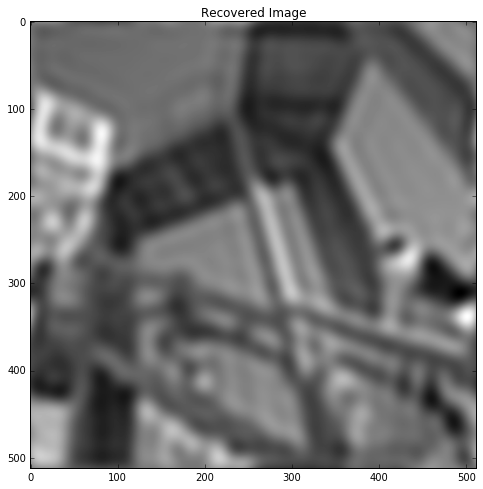

In [18]:
# Start with an initial guess for X.
X_rec = np.ones(Y.shape)

# Define gamma. For simplicity we will set it to one.
gamma = 1

# Set the number of iterations.
n_iter = 100

# Then iterate until we have a solution.
for i in range(n_iter):
    X_rec -= gamma * grad(Y, X_rec, M)
    print i + 1, 'F(X) =', np.linalg.norm(fftconvolve(X_rec, M) - Y)
    
# Display
plt.imshow(X_rec, cmap='gray')
plt.title('Recovered Image')
plt.show()

Did it work?

Try increasing the number of iterations. Does this improve the results?

---

## Hints

** Exercise 1 Hints **

1. You do not need to redefine the function for the normal equation. 
2. The polynomial should have as many degrees as there are good Indiana Jones films. 

** Exercise 2 Hints **

1. The original observed image, Y, is still in memory.
2. The noise is ADDITIVE.

---

## Exercise Solutions

**<font color="red">Warning!</font>** Try your best to solve all of the exercises on your own before checking the answers.

<br />

### Exercise 1 Solution

```Python

# Define the matrix operator X here:
X = np.array([np.ones(x.size), x, x ** 2, x ** 3]).T

# Calculate the model parameters A here:
A = normal_eq(X, y)

```

### Exercise 2 Solution

```Python

# Set the noise level.
sigma = 0.0001

# Define the noise.
N = sigma * np.random.randn(*Y.shape)

# Add noise to the observed image.
Y_noisy = Y + N

# Recover the original image.
X_rec = fftdeconvolve(Y_noisy, M)

```